###(NLP) Sentiment analysis of the medical records-Using LSTM RNN

In [56]:
#import required tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [57]:
df = pd.read_csv('/content/Independent_Medical_Reviews.csv')
# df.sample(n = 3)
df.head()

,Reference ID,Report Year,Diagnosis Category,Diagnosis Sub Category,Treatment Category,Treatment Sub Category,Determination,Type,Age Range,Patient Gender,Findings
0,MN16-22639,2016,Infectious,Hepatitis,Pharmacy/Prescription Drugs,Anti-virals,Overturned Decision of Health Plan,Medical Necessity,41-50,Male,Nature of Statutory Criteria/Case Summary: An ...
1,MN16-22638,2016,Mental,Eating Disorder,Mental Health Treatment,Residential Treatment Center - Admission,Upheld Decision of Health Plan,Medical Necessity,21-30,Female,Nature of Statutory Criteria/Case Summary: An...
2,MN16-22637,2016,Autism Spectrum,Autism-PDD-NOS,Autism Related Treatment,Speech Therapy,Upheld Decision of Health Plan,Medical Necessity,0-10,Female,Nature of Statutory Criteria/Case Summary: Th...
3,EI16-22636,2016,Prevention/Good Health,NaN,"Diagnostic Imaging, Screening and Testing",Mammography,Overturned Decision of Health Plan,Experimental/Investigational,65+,Female,Nature of Statutory Criteria/Case Summary: An ...
4,EI06-5319,2006,Cardiac/Circulatory,NaN,Cardio Vascular,NaN,Upheld Decision of Health Plan,Experimental/Investigational,51-64,Male,Physician 1: The patient is a 62-year-old male...


In [72]:
# select the relevant feature('Findings') and target('Determination') to create the main dataframe
# display three random examples

main_df = df[['Findings', 'Determination']]
main_df.sample(3)

,Findings,Determination
5836,A 64-year-old male enrollee has requested puls...,Overturned Decision of Health Plan
16211,The patient is a 53-year-old female with a his...,Upheld Decision of Health Plan
5756,A 21-year-old female enrollee has requested pe...,Upheld Decision of Health Plan


In [59]:
main_df.shape

(19245, 2)

In [60]:
main_df['Determination'].unique()

array(['Overturned Decision of Health Plan',
       'Upheld Decision of Health Plan'], dtype=object)

In [62]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19245 entries, 0 to 19244
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Findings       19225 non-null  object
 1   Determination  19245 non-null  object
dtypes: object(2)
memory usage: 300.8+ KB


In [61]:
# # get number of examples and number of features

# print(f'Number of examples before cleaning = {main_df.shape[0]}')
# print(f'Number of examples = {main_df.shape[1]}')

In [6]:
# confirm that feature and label are text data ('object')
data_types = main_df.dtypes
data_types

Findings         object
Determination    object
dtype: object

### Feature scaling->Nominal to ordinal

In [71]:
# main_df = pd.get_dummies(main_df, columns=['Determination'])

In [73]:
mask = (main_df.Determination == 'Overturned Decision of Health Plan')

In [74]:
mask

0         True
1        False
2        False
3         True
4        False
         ...  
19240     True
19241    False
19242    False
19243     True
19244    False
Name: Determination, Length: 19245, dtype: bool

In [76]:
new_target

0        1
1        0
2        0
3        1
4        0
        ..
19240    1
19241    0
19242    0
19243    1
19244    0
Name: Determination, Length: 19245, dtype: int64

In [75]:
# Transform labels from nominal categories to ordinal categories
mask = (main_df.Determination == 'Overturned Decision of Health Plan') # create mask
new_target = mask.astype('int') # change mask to integers
main_df = main_df.assign(Determination = new_target)

In [77]:
main_df.head(5)

,Findings,Determination
0,Nature of Statutory Criteria/Case Summary: An ...,1
1,Nature of Statutory Criteria/Case Summary: An...,0
2,Nature of Statutory Criteria/Case Summary: Th...,0
3,Nature of Statutory Criteria/Case Summary: An ...,1
4,Physician 1: The patient is a 62-year-old male...,0


In [80]:
main_df.isna().sum()

Findings         20
Determination     0
dtype: int64

In [81]:
# check for missing values or entries
num_missing = main_df.isna().sum()
num_missing

Findings         20
Determination     0
dtype: int64

In [82]:
# since missing values are from the feature vector ('Findings'), remove all missing values
main_df = main_df.dropna(axis = 0)
main_df.isna().sum() # confirm that there are no missing entries

Findings         0
Determination    0
dtype: int64

In [84]:
# # show numbers of data points and features
# print(f'Number of examples = {main_df.shape[0]}')
# print(f'Number of examples = {main_df.shape[1]}')

In [85]:
# # display final dataset
# main_df.head(2)

### Function to plot, predict for new data, and for learning rate

In [86]:
# plot_training_log - to plot train loss vs val loss & train accuracy vs val accuracy
# get predictions - to make predictions
# scheduler : to dynamically set learning training rate throughout the training phase

def plot_training_log(history):
    history = pd.DataFrame(data = history.history, index = history.epoch)
    fig, ax = plt.subplots(2,1, sharex = True, figsize = (5,10))
    ax[0].plot(history.index, history.loss, label = 'Train')
    ax[0].plot(history.index, history.val_loss, label = 'Validation')
    ax[0].set_ylim(0.0,0.5)
    ax[0].set_title('Train_loss vs Val_loss')
    ax[0].legend()
    ax[0].set_ylabel('Loss')
    ax[1].plot(history.index, history.accuracy, label = 'Train')
    ax[1].plot(history.index, history.val_accuracy, label = 'Validation')
    ax[1].set_ylim(0.5, 1.0)
    ax[1].set_title('Train_Accuracy vs Val_Accuracy')
    ax[1].legend()
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epochs')
    plt.show()

def get_predictions(input, label):
    logit = model.predict(input)
    pred = np.squeeze((logit >= 0.0).astype('int'))
    return pred, label

def scheduler(epoch, lr):
    if epoch < 10:
        return 0.001
    else:
        return 0.0001

In [88]:
data_set

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [87]:
# Create a tf.data.Dataset pipeline
Input = main_df['Findings']
output = main_df['Determination']
data_set = tf.data.Dataset.from_tensor_slices((Input,output))

In [90]:
# use feature vector to create token vocabulary
vocab_size = 1000
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens = vocab_size)
data_input = data_set.map(lambda x,y: x)
text_vectorizer.adapt(data_input)

In [91]:
# sanity check
original_text = main_df['Findings'][0][:70]
vocab = np.array(text_vectorizer.get_vocabulary())
text_vectors = text_vectorizer(original_text).numpy()
transcript = ' '.join(vocab[text_vectors])
print(f'Original text: {original_text}')
print('\n')
print(f'tokens: {text_vectors}')
print('\n')
print(f'Transcript: {transcript}')

Original text: Nature of Statutory Criteria/Case Summary: An enrollee has requested H


tokens: [132   3 181 182 164  27  34  12  17   1]


Transcript: nature of statutory criteriacase summary an enrollee has requested [UNK]


In [92]:
# batch, shuffle and cache the dataset to improve model robustness

data_set = data_set.batch(64).shuffle(buffer_size = 1000).cache().prefetch(buffer_size = tf.data.AUTOTUNE)

### splitting of the data->Train, Test, Valid data

In [94]:
 ##total number of batches
 data_set.cardinality().numpy()

301

In [121]:
# # split dataset into train, validation and test sets
# # 70% - Train set, 20% - Validation set, 10% - Test set

# num_batches = data_set.cardinality().numpy()
# num_train = int(num_batches * 0.7) #70%
# num_val = int(num_batches * 0.2) #20%
# num_test = int(num_batches * 0.1)+1 #10%

# ##distributing the data
# train_set = data_set.take(num_train)
# val_set = data_set.skip(num_train).take(num_val)
# test_set = data_set.skip(num_train+num_val).take(num_test)

# # sanity check
# print(f'Number of train batches {train_set.cardinality().numpy()}, Number of val batches {val_set.cardinality().numpy()}, Number of test batches {test_set.cardinality().numpy()}')

In [119]:
# split dataset into train, validation and test sets
# ~80% - Train set, ~19.99% - Validation set, ~0.01% - Test set

train_size = 0.8
num_batches = data_set.cardinality().numpy()
num_train = int(num_batches * train_size)
num_val = num_batches - num_train - 1
num_test = 1

In [120]:
num_train, num_val,  num_test

(240, 60, 1)

In [122]:
# split dataset into train, validation and test sets
# ~80% - Train set, ~19.99% - Validation set, ~0.01% - Test set

train_size = 0.8
num_batches = data_set.cardinality().numpy()
num_train = int(num_batches * train_size)
num_val = num_batches - num_train - 1
num_test = 1

train_set = data_set.take(num_train)
train_set_ = data_set.skip(num_train)
val_set = train_set_.take(num_val)
test_set = train_set_.skip(num_val)

# sanity check
print(f'Number of train batches {train_set.cardinality().numpy()}, Number of val batches {val_set.cardinality().numpy()}, Number of test batches {test_set.cardinality().numpy()}')

Number of train batches 240, Number of val batches 60, Number of test batches 1


### Model creation

In [124]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

In [125]:
model=Sequential()

In [126]:
model.add(text_vectorizer)
model.add(Embedding(vocab_size, 64, mask_zero=True))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [127]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [128]:
RoP = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [110]:
print(f'Test accuracy before model training {model.evaluate(test_set)[1]}')

31/31 [==============================] - 16s 137ms/step - loss: 0.6927 - accuracy: 0.5418
Test accuracy before model training 0.5418346524238586


In [132]:
hist=model.fit(train_set,  epochs=12, validation_data=val_set, callbacks=[RoP])

#### Another way to create model

In [19]:
# define model architecture
# set a learning rate scheduler callback
#compile model, use binary crossentropy and set 'from_logits' to True
# show model performance after training
# train model for 15 epochs

model = tf.keras.Sequential([text_vectorizer, tf.keras.layers.Embedding(vocab_size, 64, mask_zero = True),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
                             tf.keras.layers.Dense(8, activation = 'relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1)
                            ])

RoP = tf.keras.callbacks.LearningRateScheduler(scheduler)

model.compile(optimizer = tf.keras.optimizers.Adam(), loss = tf.keras.losses.BinaryCrossentropy(from_logits = True), metrics = ['accuracy'])

print(f'Test accuracy before model training {model.evaluate(test_set)[1]}')

history = model.fit(train_set, epochs=15, validation_data = val_set, callbacks = [RoP])

1/1 [==============================] - 6s 6s/step - loss: 0.6921 - accuracy: 0.5000
Test accuracy before model training 0.5
Epoch 1/15
240/240 [==============================] - 120s 476ms/step - loss: 0.5515 - accuracy: 0.5915 - val_loss: 0.4707 - val_accuracy: 0.6958 - lr: 0.0010
Epoch 2/15
240/240 [==============================] - 108s 450ms/step - loss: 0.3341 - accuracy: 0.8178 - val_loss: 0.2165 - val_accuracy: 0.9253 - lr: 0.0010
Epoch 3/15
240/240 [==============================] - 107s 449ms/step - loss: 0.2592 - accuracy: 0.8372 - val_loss: 0.2035 - val_accuracy: 0.9312 - lr: 0.0010
Epoch 4/15
240/240 [==============================] - 107s 448ms/step - loss: 0.2189 - accuracy: 0.8512 - val_loss: 0.1872 - val_accuracy: 0.9336 - lr: 0.0010
Epoch 5/15
240/240 [==============================] - 110s 460ms/step - loss: 0.3311 - accuracy: 0.7945 - val_loss: 0.1961 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 6/15
240/240 [==============================] - 112s 467ms/step - loss: 0.2

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 8)                 1032      
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [34]:
##single function to plot training loss vs validation loss and Training accuracy vs validation accuracy
# plot_training_log(history)

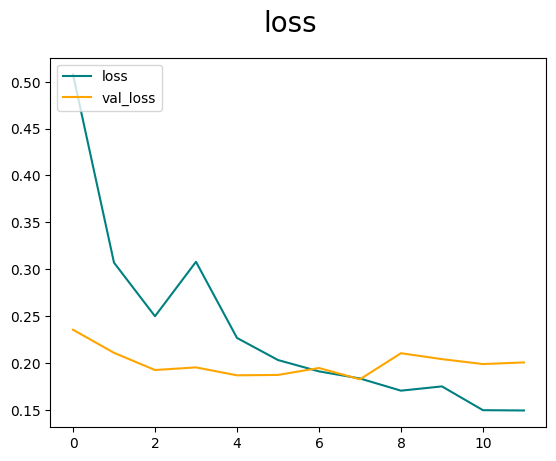

In [35]:
fig=plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

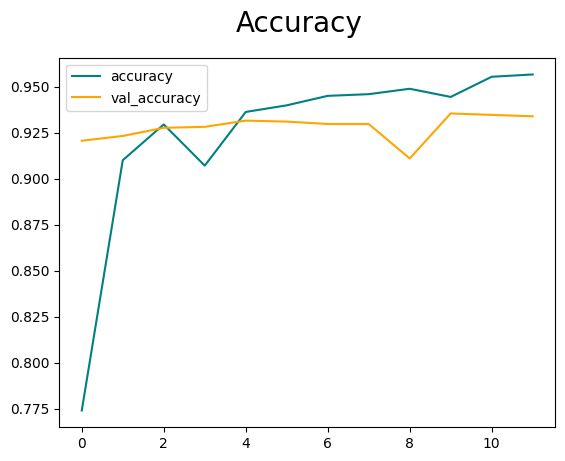

In [36]:

fig=plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [21]:
# show model performance after training

print(f'Test accuracy after model training {model.evaluate(test_set)[1]}')

1/1 [==============================] - 0s 88ms/step - loss: 0.3361 - accuracy: 0.9062
Test accuracy after model training 0.90625


### Evaluating model

In [55]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

# Initialize metrics
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

# Iterate through the entire test set
for batch in test_set.as_numpy_iterator():
    x, y = batch
    yhat = model.predict(x)

    # Update metrics for the batch
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

# Calculate final metrics
precision_result = pre.result().numpy()
recall_result = re.result().numpy()
accuracy_result = acc.result().numpy()

print(f'Precision on Test data: {precision_result:.3f}')
print(f' Recall on Test data: {recall_result:.3f}')
print(f'Accuracy on Test data: {accuracy_result:.3f}')

2/2 [==============================] - 0s 56ms/step
Precision on Test data: 0.853
 Recall on Test data: 0.906
Accuracy on Test data: 0.875


In [22]:
# compare true label of a randomly selected text from the dataset to the predcited label

random_idx = np.random.choice(main_df.shape[0])
sample_input = main_df[['Findings']].values[random_idx]
sample_output = main_df['Determination'].values[random_idx]

v, n = get_predictions(sample_input, sample_output)
print(f'Predicted output is {v} and True label is {n}')

1/1 [==============================] - 3s 3s/step
Predicted output is 0 and True label is 0
